In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np
from datetime import datetime
from collections import defaultdict, OrderedDict
import scipy
import copy

import term_hiearchy
import re
from tqdm.notebook import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Regression Analyses 

Change of language use over time.  Details of dataset generation is available in notebook 0 and details of descriptive summaries are in notebook 1.

First we need to parse the dataset (renaming it for consistency with manuscript) and generate a count of term uses by user. 

In [2]:
query_data = pd.read_csv('../2021_04_15_inceldom_discussion_scrape/hierarchy_query_data_PROCESSED.tsv.gz', sep='\t', lineterminator='\n', index_col=False).drop('Unnamed: 0', axis=1)
post_data = pd.read_csv('../2021_04_15_inceldom_discussion_scrape/hierarchy_post_data.tsv.gz', sep='\t', lineterminator='\n', index_col=False)

query_data.loc[query_data['query_term'].str.lower().isin(['femoid', 'foid']), 'query_category'] = "Foid"
query_data.loc[query_data['query_category'] == "Homophobic Misogyny", 'query_category'] = 'Other Misogyny'
query_data.loc[(query_data['query_category'] == "Girl/Female") & (query_data['query_term'] == "girl"), 'query_category'] = 'Girl'
query_data.loc[(query_data['query_category'] == "Girl/Female") & (query_data['query_term'] == "female"), 'query_category'] = 'Female'
query_data.loc[query_data['query_category'] == "Women/Lady", 'query_category'] = 'Neutral Terms'
query_data = query_data[query_data['query_category'] != 'Transphobic']


post_data['post_datetime'] = pd.to_datetime(post_data['post_time'], unit='s')
post_data['post_id'] = post_data['post_position'].astype(str) + "_" + post_data['thread_url']
query_data['post_datetime'] = pd.to_datetime(query_data['post_time'], unit='s')
query_data['post_id'] = query_data['post_position'].astype(str) + "_" + query_data['thread_url']


category_order = ['Neutral Terms',
                  'Total Misogyny',
                  'Racist Misogyny',
                  'Stacy/Becky',
                  'Girl',
                  'Female',
                  'Foid',
                  'Other Misogyny']

total_misogyny = query_data[query_data['query_category'].isin([
    "Racist Misogyny",
    "Stacy/Becky",
    "Female",
    "Foid",
    "Girl",
    "Other Misogyny"])]
total_misogyny['query_category'] = 'Total Misogyny'
term_uses = pd.concat([query_data, total_misogyny])
term_uses = term_uses.reset_index(drop=True)

/tmp/ipykernel_78351/1517435249.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_misogyny['query_category'] = 'Total Misogyny'


We also need to include all posts with 0 term uses into our term counts:

In [3]:
# get the position of a users posts
post_data['user_post_index'] = post_data.sort_values(['post_datetime', 'post_id', 'username']).groupby('username')['post_id'].cumcount() + 1
user_post_index = post_data.set_index('post_id')['user_post_index'].to_dict()
term_uses['user_post_index'] = term_uses['post_id'].apply(lambda x: user_post_index[x.replace("title_https", '0_https')])
post_data['user_post_index'] = post_data['post_id'].apply(lambda x: user_post_index[x.replace("title_https", '0_https')])

first_post_timestamp = post_data.groupby('username')['post_time'].min()
post_data['time_of_post_since_first_post'] = post_data.apply(lambda x: x['post_time'] - first_post_timestamp[x['username']], axis=1)
user_post_time = post_data.set_index('post_id')['time_of_post_since_first_post'].to_dict()
term_uses['time_of_post_since_first_post'] = term_uses['post_id'].apply(lambda x: user_post_time[x.replace("title_https", '0_https')])
post_data['time_of_post_since_first_post'] = post_data['post_id'].apply(lambda x: user_post_time[x.replace("title_https", '0_https')])

term_use_simplified = term_uses[['username', 'user_post_index', 'time_of_post_since_first_post', 'post_id', 'post_time', 'query_category']].sort_values(['username', 'time_of_post_since_first_post', 'query_category'])
term_use_counts = pd.merge(left = term_use_simplified[['username', 'user_post_index', 'time_of_post_since_first_post', 'post_id', 'post_time']].drop_duplicates(), 
                               right = term_use_simplified.groupby(['post_id', 'query_category']).size().unstack(fill_value=0).reset_index(),
                               on='post_id',
                               how='outer',
                               validate='one_to_one')


# get all 0 posts
empty_posts = post_data[~post_data['post_id'].isin(term_use_counts['post_id'].unique())]
for category in category_order:
    empty_posts.loc[:, category] = 0
    
empty_posts = empty_posts.drop(['thread_url', 'thread_title', 'post_position', 'post_word_count', 'post_sentence_count', 'post_datetime'], axis=1)

term_use_counts_with_null = pd.concat([term_use_counts, empty_posts])

term_use_counts_with_null = term_use_counts_with_null.reset_index(drop=True)
term_use_counts_with_null = term_use_counts_with_null.sort_values(['username', 'time_of_post_since_first_post'])
term_use_counts_with_null['months_since_first_post'] = pd.to_timedelta(term_use_counts_with_null['time_of_post_since_first_post'], unit='s').astype('timedelta64[M]')

/tmp/ipykernel_78351/138571059.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_posts.loc[:, category] = 0
/tmp/ipykernel_78351/138571059.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_posts.loc[:, category] = 0
/tmp/ipykernel_78351/138571059.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Then we need to filter our users as we can't determine trends for users with fewer than 3 months of posting activity.  This filtered dataset can then be used to create monthly averages of term uses per user.

In [4]:
# filter uses with < 3 months of posting activity
months_of_posting = term_use_counts_with_null.groupby('username')['months_since_first_post'].nunique()

term_use_counts_with_null_3_or_more_months = term_use_counts_with_null[term_use_counts_with_null['username'].isin(months_of_posting[(months_of_posting>=3)].index)]

monthly_averages = term_use_counts_with_null_3_or_more_months.groupby(['username', 'months_since_first_post'])[category_order].mean().reset_index()

We need our response variable (i.e., average monthly use of different categories per user) to be normally distributed so we apply a log transform to the monthly averages:

In [5]:
for category in category_order:
    monthly_averages[category.lower().replace(' ', '_').replace('/', '_') + "_log"] = np.log(monthly_averages['Total Misogyny'] + 1)

Then we can run a mixed linear model with random effect intercept and slope from the username and a fixed effect of months since a user's first post  

In [6]:
# mixed_lm = {}
# for category in category_order:
#     category_log = category.lower().replace(' ', '_').replace('/', '_') + "_log"
#     md = smf.mixedlm(category_log + " ~ months_since_first_post", monthly_averages, 
#                      groups=monthly_averages["username"], re_formula="~months_since_first_post")
#     mixed_lm[category] = md.fit()

However, we can run an even simpler model which is just the difference between average term use between a user's first and last month against the total number of months a user has been active.

We find these simple models actually fit the data far more effectively (much better likelihood) than the linear mixed model

## Figure 2

In [7]:
first_per_user = monthly_averages.loc[monthly_averages.groupby('username')['months_since_first_post'].idxmin()].set_index('username')
last_per_user = monthly_averages.loc[monthly_averages.groupby('username')['months_since_first_post'].idxmax()].set_index('username')

last_per_user['total_months'] = last_per_user['months_since_first_post']
for category in category_order:
    last_per_user[category] = last_per_user[category] - first_per_user[category] 
    
# simple models
ols_models = {}
for category in category_order:
    md = sm.OLS(exog=last_per_user[['months_since_first_post']], 
               endog=last_per_user[category])
    mdf = md.fit()
    ols_models[category] = mdf

In [8]:
ols_model_summary = {'Term Category': [], 'Months Since First Post of User': [], 'p-value': [], 'R-squared': []} 
for category in category_order:
    ols_model_summary['Term Category'].append(category)
    ols_model_summary['Months Since First Post of User'].append(f"{ols_models[category].params.loc['months_since_first_post']:.4f}")
    ols_model_summary['p-value'].append(f"{ols_models[category].pvalues.loc['months_since_first_post']:.4f}")
    ols_model_summary['R-squared'].append(f"{ols_models[category].rsquared * 100:.2f}%")

# change_data = pd.melt(last_per_user.loc[:, ['months_since_first_post'] + category_order], id_vars='months_since_first_post', 
#         var_name='Term Category', value_name='Overall Change in Average Term Usage').rename(columns={'months_since_first_post': 'Months Since First Post'})
# sns.lmplot(data = change_data, x='Months Since First Post', hue_order = category_order, y='Overall Change in Average Term Usage', hue='Term Category', scatter=False)
# plt.title("No Overall Relationship between Time on Forum and Term Use")
# plt.savefig('../results/figure_2_relationship_between_time_and_term_use.png', dpi=300, bbox_inches='tight')
ols_model_summary = pd.DataFrame(ols_model_summary)
_, ols_model_summary['p-value (FDR-corrected)'] = statsmodels.stats.multitest.fdrcorrection(ols_model_summary['p-value'].astype(float))
ols_model_summary['p-value (FDR-corrected)'] = ols_model_summary['p-value (FDR-corrected)'].apply(lambda x: f"{x:.4f}")
ols_model_summary = ols_model_summary.drop('p-value', axis=1)
ols_model_summary.to_csv('../results/figure_2_relationship_between_time_and_term_use.csv', sep='\t', index=False)

In [9]:
ols_model_summary[ols_model_summary['p-value (FDR-corrected)'].astype(float) < 0.05]

,Term Category,Months Since First Post of User,R-squared,p-value (FDR-corrected)
1,Total Misogyny,-0.0019,0.33%,0.0064
3,Stacy/Becky,-0.0003,0.26%,0.0131
4,Girl,-0.0014,0.64%,0.0000
7,Other Misogyny,-0.0007,0.20%,0.0290


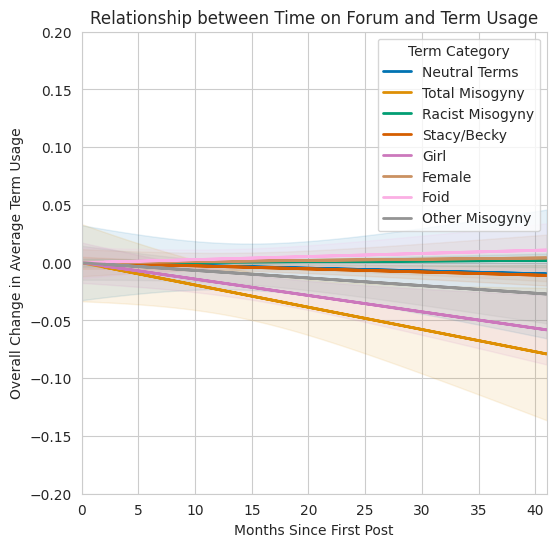

In [10]:
def plot_ci_manual(t, s_err, n, x, x2, y2, color, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color=color, alpha=0.1)
    return ax

fig, ax = plt.subplots(figsize=(6,6))

for category, category_color in zip(category_order,  sns.color_palette('colorblind', 8).as_hex()):
    model = ols_models[category]

    x = pd.concat([pd.Series([0]), last_per_user['months_since_first_post']])
    y = pd.concat([pd.Series([0]), last_per_user[category]])

    # Statistics
    n = model.nobs                                             # number of observations
    m = model.params.shape[0]                                  # number of parameters
    dof = model.df_resid - model.df_model                      # degrees of freedom
    t = scipy.stats.t.ppf(0.975, n - m)                        # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    chi2 = np.sum((model.resid / model.fittedvalues)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(model.resid**2) / dof)                    # standard deviation of the error

    # Plotting --------------------------------------------------------------------

    # Fit
    ax.plot(x, pd.concat([pd.Series([0]), model.fittedvalues]), "-", color=category_color, linewidth=2, label=category)  

    x2 = np.linspace(0, 41, 100)
    y2 = model.predict(x2)

    # Confidence Interval (select one)
    plot_ci_manual(t, s_err, n, x, x2, y2, category_color, ax=ax)
    #plot_ci_bootstrap(x, y, resid, ax=ax)

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
    
plt.ylim(-0.2, 0.2)
plt.xlim(0,41)
plt.title("Relationship between Time on Forum and Term Usage")
plt.ylabel('Overall Change in Average Term Usage')
plt.xlabel('Months Since First Post')
plt.legend(title='Term Category', loc='best')
plt.savefig('../results/figure_2_relationship_between_time_and_term_use.png', dpi=300, bbox_inches='tight')

Now let's decompose our users into individual linear models to see if there are multiple trends at play

In [11]:
np.seterr(divide = 'ignore')
per_user_models = []

for user, user_data in tqdm(monthly_averages.groupby('username')):
#for user, user_data in tqdm(a.groupby('username')):
    per_user_model = {'Username': [], 'Term Category': [], 'AIC': [], 'Lower_CI': [], 'Upper_CI': [], 'Coef': [], 'Constant': [], 'P-value': [], 'R-squared (Adj)': []}

    for category in category_order:
        
        try:
            X = user_data['months_since_first_post']
            Y = user_data[category]
            X = sm.add_constant(X)
            mod = sm.OLS(Y,X)
            res = mod.fit()
            per_user_model['Username'].append(user)
            per_user_model['Term Category'].append(category)
            per_user_model['Lower_CI'].append(res.conf_int().loc['months_since_first_post', 0])
            per_user_model['Upper_CI'].append(res.conf_int().loc['months_since_first_post', 1])
            per_user_model['Coef'].append(res.params.loc['months_since_first_post'])
            per_user_model['Constant'].append(res.params.loc['const'])
            per_user_model['AIC'].append(res.aic)
            per_user_model['P-value'].append(res.pvalues.loc['months_since_first_post'])
            per_user_model['R-squared (Adj)'].append(res.rsquared_adj)

        except ValueError:
            per_user_model['Username'].append(user)
            per_user_model['Term Category'].append(category)
            per_user_model['Lower_CI'].append(np.nan)
            per_user_model['Upper_CI'].append(np.nan)
            per_user_model['Coef'].append(np.nan)
            per_user_model['Constant'].append(np.nan)

            per_user_model['AIC'].append(np.nan)
            per_user_model['P-value'].append(np.nan) 
            per_user_model['R-squared (Adj)'].append(np.nan)
      
    # correct p-values using Benjamini/Hochberg (positive or indenepdent categories) FDR for term categories (within each user) 
    rejected, corr_pval = statsmodels.stats.multitest.fdrcorrection(per_user_model['P-value'], alpha=0.05, method='poscorr', is_sorted=False)
    per_user_model['P-value (FDR-BH Adj)'] = corr_pval
    per_user_models.append(pd.DataFrame(per_user_model))
    
model_fits_df = pd.concat(per_user_models)
model_fits_df = model_fits_df.reset_index(drop=True)
model_fits_df.to_csv('../results/appendix/individual_model_fits.csv', index=False, sep='\t')

  0%|          | 0/3043 [00:00<?, ?it/s]

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/bioinf/anaconda3/envs/incels/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ss

Then we can then split these user+category models into those increasing (gradient/coefficient CI > 0), decreasing (gradient/coefficient CI < 0), and neutral (gradient/coefficient CI contains 0).

In [12]:
positive_users = model_fits_df[model_fits_df['Lower_CI'] > 0]
positive_reg = positive_users.groupby('Term Category')['Username'].nunique()
positive_reg.name = "Increasing Term Use" 

negative_users = model_fits_df[model_fits_df['Upper_CI'] < 0]
negative_reg = negative_users.groupby('Term Category')['Username'].nunique()
negative_reg.name = "Decreasing Term Use"

neutral_users = model_fits_df.loc[set(model_fits_df.index) - (set(positive_users.index).union(set(negative_users.index)))]
neutral_reg = neutral_users.groupby('Term Category')["Username"].nunique()
neutral_reg.name = "Constant Term Use"

user_breakdown = pd.concat([positive_reg, negative_reg, neutral_reg], axis=1)

total_reg = model_fits_df.groupby('Term Category')["Username"].nunique()
for col in user_breakdown:
    user_breakdown[col] = user_breakdown[col] / total_reg * 100
    
user_breakdown_melt = pd.melt(user_breakdown.reset_index(), id_vars='Term Category', var_name='User Category', value_name='% of Users')


model_fits_df.loc[positive_users.index, 'User Category'] = "Increasing Term Use"
model_fits_df.loc[negative_users.index, 'User Category'] = "Decreasing Term Use"
model_fits_df.loc[neutral_users.index, 'User Category'] = "Constant Term Use"

positive_r = positive_users.groupby('Term Category')['R-squared (Adj)'].mean()
positive_r.name = "Increasing Term Use"

negative_r = negative_users.groupby('Term Category')['R-squared (Adj)'].mean()
negative_r.name = "Decreasing Term Use"

neutral_r = neutral_users.groupby('Term Category')['R-squared (Adj)'].mean()
neutral_r.name = "Constant Term Use"

r_sq_breakdown = pd.concat([positive_r, negative_r, neutral_r], axis=1)
r_sq_breakdown_melt = pd.melt(r_sq_breakdown.reset_index(), id_vars='Term Category', var_name='User Category', value_name='Mean $R^2$ %')
r_sq_breakdown_melt['Mean $R^2$ %'] = r_sq_breakdown_melt['Mean $R^2$ %'] * 100

individual_summary = pd.merge(user_breakdown_melt, r_sq_breakdown_melt, on=['Term Category', 'User Category'], how='outer', validate='one_to_one')
individual_summary = individual_summary.set_index('Term Category').loc[category_order].reset_index()
individual_summary.to_csv('../results/appendix/Appedix_D_individual_model_summaries.tsv', sep='\t',index=False)

/tmp/ipykernel_78351/157948360.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  neutral_users = model_fits_df.loc[set(model_fits_df.index) - (set(positive_users.index).union(set(negative_users.index)))]


Now we can summarise the general trends across categories.

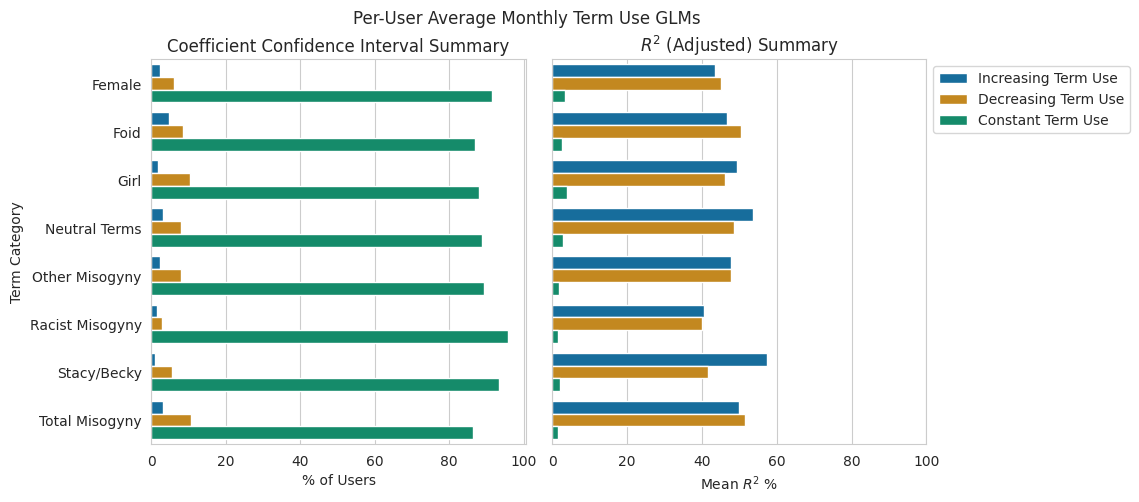

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=False, figsize=(10,5))
fig.suptitle('Per-User Average Monthly Term Use GLMs')

sns.barplot(data=user_breakdown_melt, y='Term Category', x='% of Users', hue='User Category', ax=axes[0])
#plt.legend(loc=(1,0.8))
axes[0].set_title('Coefficient Confidence Interval Summary')
sns.barplot(data = r_sq_breakdown_melt, y='Term Category', x='Mean $R^2$ %', hue='User Category', ax=axes[1])
axes[1].set_title('$R^2$ (Adjusted) Summary')
axes[1].set_ylabel('')
axes[1].set_xlim(0, 100)
axes[0].legend().set_visible(False)
axes[1].legend(bbox_to_anchor=(1,1))
plt.subplots_adjust(wspace=0.07)
#plt.savefig('glm_summaries.png', dpi=300, bbox_inches='tight')
#plt.legend(show=False)#

## Diagnostic Checks

Additional analyses evaluating overall trends on the forum and ensuring users are consistent over time.

- First we want to look at overall temporal prevalence over time

In [14]:
term_uses['post_datetime_year_month'] = term_uses['post_datetime'].dt.strftime('%Y-%m')
post_data['post_datetime_year_month'] = post_data['post_datetime'].dt.strftime('%Y-%m')

weekly_post_count = term_uses.groupby(['post_datetime_year_month', 'query_category'])['post_id'].nunique().reset_index(name='Number of Posts')
total_posts_per_week = post_data['post_datetime_year_month'].value_counts()
weekly_post_count = weekly_post_count.set_index('post_datetime_year_month')
weekly_post_count['Total Posts'] = total_posts_per_week
weekly_post_count = weekly_post_count.reset_index()
weekly_post_count['% Posts'] = weekly_post_count['Number of Posts'] / weekly_post_count['Total Posts'] * 100
weekly_post_count['post_datetime_year_month'] = pd.to_datetime(weekly_post_count['post_datetime_year_month'])

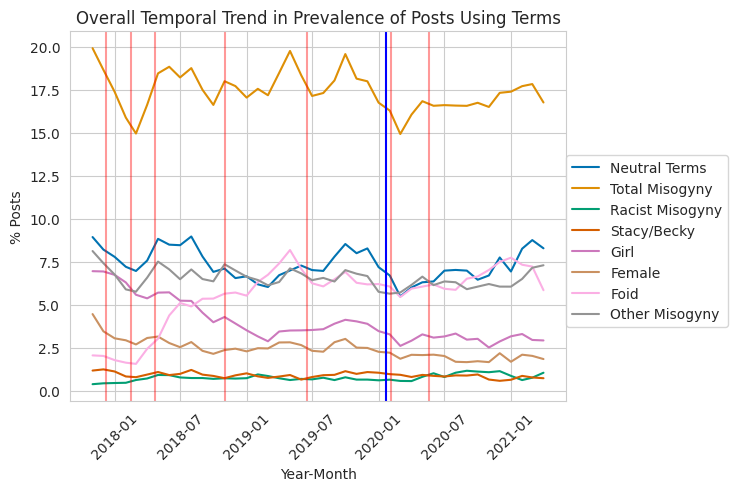

In [15]:
fig, ax = plt.subplots()
sns.lineplot(ax = ax, hue_order = category_order, data = weekly_post_count.rename(columns={'query_category': 'Category', 'post_datetime_year_month': 'Year-Month'}), hue='Category', y='% Posts', x='Year-Month')
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if n % 5!= 0:
#         label.set_visible(False)

_ = plt.xticks(rotation=45)
plt.legend(loc=(1,.2))


plt.axvline(pd.to_datetime('2017-12-7'), color='red', alpha=0.4)
plt.axvline(pd.to_datetime('2018-02-14'), color='red', alpha=0.4)
plt.axvline(pd.to_datetime('2018-04-23'), color='red', alpha=0.4)
plt.axvline(pd.to_datetime('2018-11-02'), color='red', alpha=0.4)
plt.axvline(pd.to_datetime('2019-06-17'), color='red', alpha=0.4)
plt.axvline(pd.to_datetime('2020-02-04'), color='red', alpha=0.4)
plt.axvline(pd.to_datetime('2020-05-20'), color='red', alpha=0.4)

plt.axvline(pd.to_datetime('2020-01-22'), color='blue')

plt.title('Overall Temporal Trend in Prevalence of Posts Using Terms')
plt.savefig('../results/appendix/overall_trend_in_terms_being_used.png', dpi=300, bbox_inches='tight')

- As we have left-censorship (and right) of user post history i.e., we started a scrape in the midst of certain users posting. We want to make sure that users which began before the scrape (proxied by those already posting within the first 3 months of scraped data) are similar to those in the rest of the dataset (those posting for the first time >=6 months after the scrape starts).

In [16]:
first_posts = post_data[post_data['user_post_index'] == 1]
#users that posted in first 3 months of scrape
users_who_predate_scrape = first_posts.loc[first_posts['post_datetime'] < pd.to_datetime('2018-02-08'), 'username'].unique()
users_who_predate_scrape = model_fits_df[model_fits_df['Username'].isin(users_who_predate_scrape)]
print(users_who_predate_scrape['Username'].nunique())

# users who made first post > 6 months after we started scrape i.e., potential new users
users_who_started_within_scrape = first_posts.loc[post_data['post_datetime'] > pd.to_datetime('2018-05-08'), 'username'].unique()
users_who_started_within_scrape = model_fits_df[model_fits_df['Username'].isin(users_who_started_within_scrape)]
print(users_who_started_within_scrape['Username'].nunique())

users_who_predate_scrape_breakdown = users_who_predate_scrape.groupby('Term Category')['User Category'].value_counts().reset_index(name='Number of Users').set_index("Term Category")
user_count = users_who_predate_scrape.groupby('Term Category')["Username"].nunique()
users_who_predate_scrape_breakdown['% of Users'] = users_who_predate_scrape_breakdown['Number of Users'] / user_count * 100
users_who_predate_scrape_breakdown = users_who_predate_scrape_breakdown.reset_index()

users_who_started_within_scrape_breakdown = users_who_started_within_scrape.groupby('Term Category')['User Category'].value_counts().reset_index(name='Number of Users').set_index("Term Category")
user_count = users_who_started_within_scrape.groupby('Term Category')["Username"].nunique()
users_who_started_within_scrape_breakdown['% of Users'] = users_who_started_within_scrape_breakdown['Number of Users'] / user_count * 100
users_who_started_within_scrape_breakdown = users_who_started_within_scrape_breakdown.reset_index()

684
1990


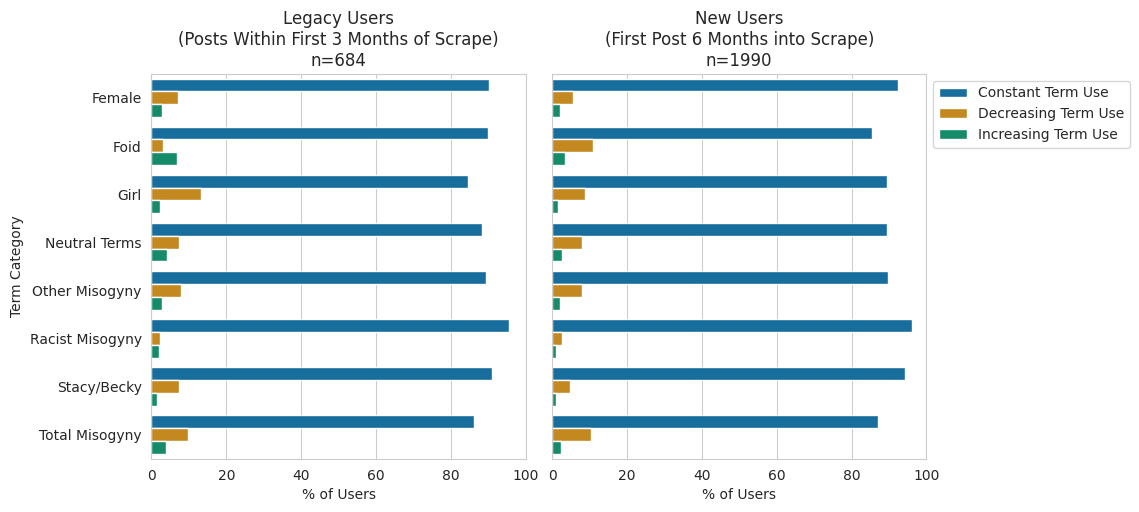

In [17]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=False, figsize=(10,5))
sns.barplot(data=users_who_predate_scrape_breakdown, y='Term Category', x='% of Users', hue='User Category', ax=axes[0])
sns.barplot(data=users_who_started_within_scrape_breakdown, y='Term Category', x='% of Users', hue='User Category', ax=axes[1])

axes[0].set_title('Legacy Users\n(Posts Within First 3 Months of Scrape)\nn=684')
axes[1].set_title('New Users\n(First Post 6 Months into Scrape)\nn=1990')
axes[1].set_ylabel('')
axes[0].set_xlim(0, 100)
axes[1].set_xlim(0, 100)

axes[0].legend().set_visible(False)
axes[1].legend(bbox_to_anchor=(1,1))
plt.subplots_adjust(wspace=0.07)
plt.savefig('../results/appendix/comparing_prescrape_and_new_users.png', dpi=300, bbox_inches='tight')
#users_who_started_within_scrape_breakdown